# Perform object segmentation with pollen-vision

Learn how to perform object segmentation with the pollen-vision library, using the MobileSAM model.

MobileSAM is a lighter version of SAM, a segmentation model developed by Meta AI.

💡 In this notebook, we assume that you have already checked the notebook dedicated to zero shot object detection as we will also perform object detection here.

![Object segmentation from Reachy's egocentric view](https://media.githubusercontent.com/media/pollen-robotics/pollen-vision/99-make-the-notebooks-runnable-on-google-colab/examples/vision_models_examples/gif/reachy_kitchen_masks.gif)

## A word on SAM and Mobile SAM

SAM stands for Segment Anything Model. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training developed by Meta AI. With SAM, you can just give a point to the model to predict the mask for a single object of interest.

In 2023, researchers from Kyung Hee University developed MobileSAM, a lighter version of SAM which allows SAM to be run on mobile devices. In pollen-vison we are using the implementation of MobileSAM from its authors. Check the [MobileSAM paper](https://arxiv.org/pdf/2306.14289.pdf), its [GitHub repository](https://github.com/ChaoningZhang/MobileSAM) and the [orginal SAM paper](https://arxiv.org/pdf/2304.02643.pdf) for more information. 

Credits to Chaoning Zhang et al. from Kyung Hee University and to Alexander Kirillov et al. from Meta AI for developing this and making it open source!

## Setup environment

> Note: If you are working locally on your machine and have already installed the library from source, discard the following.

We need to first install the pollen-vision library. We will install the library from source, this might take a couple of minutes as there are quite heavy dependencies.

In [1]:
!pip install "pollen-vision[vision] @ git+https://github.com/pollen-robotics/pollen-vision.git@99-make-the-notebooks-runnable-on-google-colab"

  Cloning https://github.com/pollen-robotics/pollen-vision.git (to revision 99-make-the-notebooks-runnable-on-google-colab) to /tmp/pip-install-nus0ydh9/pollen-vision_34a9799dca794dcd92424a0682e138b3
  Running command git clone --filter=blob:none --quiet https://github.com/pollen-robotics/pollen-vision.git /tmp/pip-install-nus0ydh9/pollen-vision_34a9799dca794dcd92424a0682e138b3
  Running command git checkout -b 99-make-the-notebooks-runnable-on-google-colab --track origin/99-make-the-notebooks-runnable-on-google-colab
  Switched to a new branch '99-make-the-notebooks-runnable-on-google-colab'
  Branch '99-make-the-notebooks-runnable-on-google-colab' set up to track remote branch '99-make-the-notebooks-runnable-on-google-colab' from 'origin'.
  Resolved https://github.com/pollen-robotics/pollen-vision.git to commit f87ad3d6d666cb9b2d7b3626332deafd065d03e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  

## Initialize MobileSAM

Let's instanciate a MobileSAM wrapper to prepare the object segmentation.

In [3]:
import numpy as np
from PIL import Image

from pollen_vision.vision_models.object_segmentation import MobileSamWrapper

In [4]:
object_segmentation_wrapper = MobileSamWrapper()

## Import example image

Here we will import an example image to test the OwlViT wrapper. We will use an image from the [reachy-doing-things image dataset](https://huggingface.co/datasets/pollen-robotics/reachy-doing-things) available on Hugging Face. In this dataset, we captured images from an egocentric view of Reachy doing manipulation tasks while being teleoperated.

Feel fry to try the object detection with your own image instead!

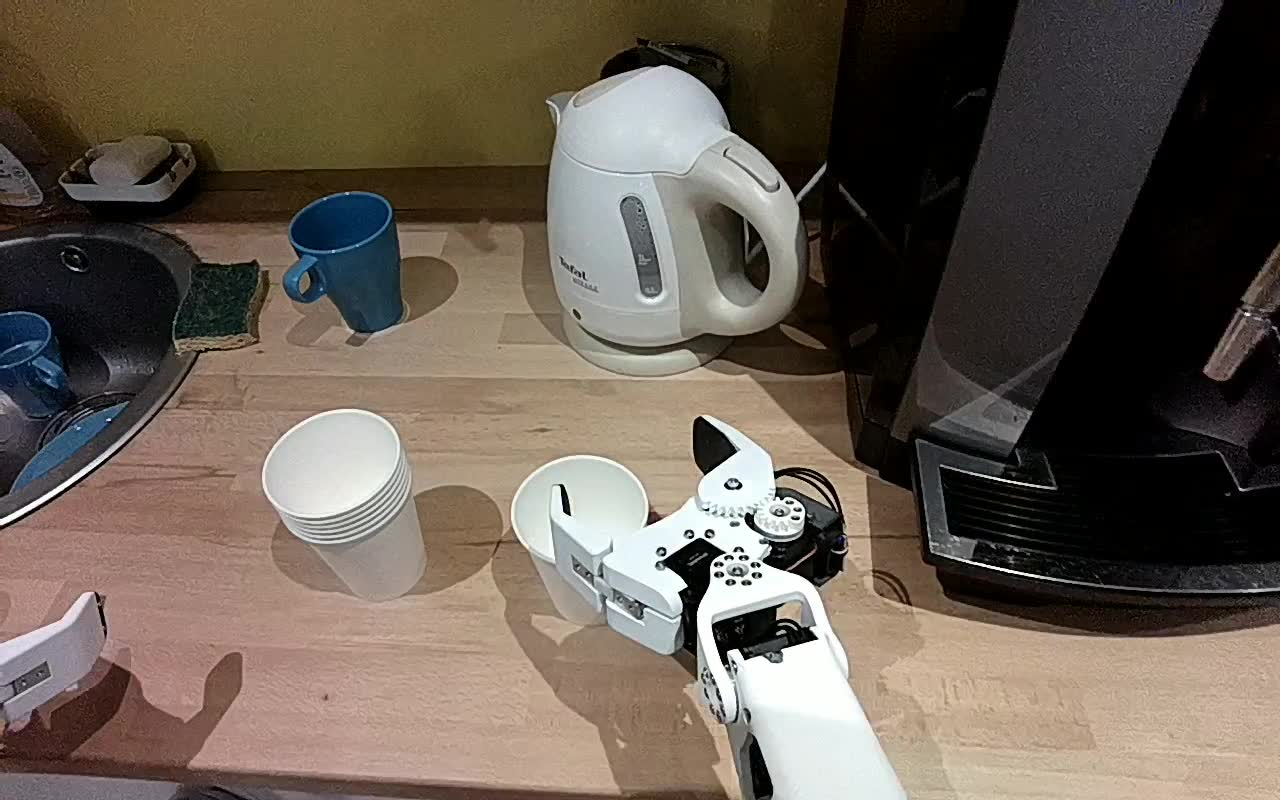

In [11]:
from datasets import load_dataset

dataset = load_dataset("pollen-robotics/reachy-doing-things", split="train")

img = dataset[12]['image']
img

Let's perform object segmentation on objects Reachy could grasp.

## First: object detection

To obtain the segmentation, we first need to do object detection in the image to give inputs to MobileSAM. MobileSAM (and SAM as well) takes either a point, a list of points or a bounding box of an object to perform the segmentation. We show in this example how to use bounding boxes of objects as input. So let's get bounding boxes for objects Reachy could grasp, using the OwlViT wrapper.

In [12]:
from pollen_vision.vision_models.object_detection import OwlVitWrapper

object_detection_wrapper = OwlVitWrapper()

If you chose your own image, replace the *candidate_labels* argument with your own list of objects candidates.

In [13]:
predictions = object_detection_wrapper.infer(
    im=np.array(img), candidate_labels=["blue mug", "paper cup", "kettle", "sponge"], detection_threshold=0.12
)
predictions

[{'score': 0.2898854613304138,
  'label': 'blue mug',
  'box': {'xmin': 277, 'ymin': 194, 'xmax': 412, 'ymax': 343}},
 {'score': 0.18099206686019897,
  'label': 'sponge',
  'box': {'xmin': 167, 'ymin': 256, 'xmax': 269, 'ymax': 352}},
 {'score': 0.15593598783016205,
  'label': 'kettle',
  'box': {'xmin': 539, 'ymin': 46, 'xmax': 821, 'ymax': 380}},
 {'score': 0.13799072802066803,
  'label': 'paper cup',
  'box': {'xmin': 258, 'ymin': 404, 'xmax': 431, 'ymax': 600}}]

We can extract the bounding boxes from the predictions, we will need them as input for the segmentation.

In [14]:
from pollen_vision.vision_models.utils import get_bboxes

bboxes = get_bboxes(predictions)

N.B.: the format returned for the bounding boxes is *[xmin, ymin, xmax, ymax]*

### Visualize object detections

You can visualize easliy the predictions of the object detection model with the *Annotator* class from utils.

In [15]:
from pollen_vision.vision_models.utils import Annotator

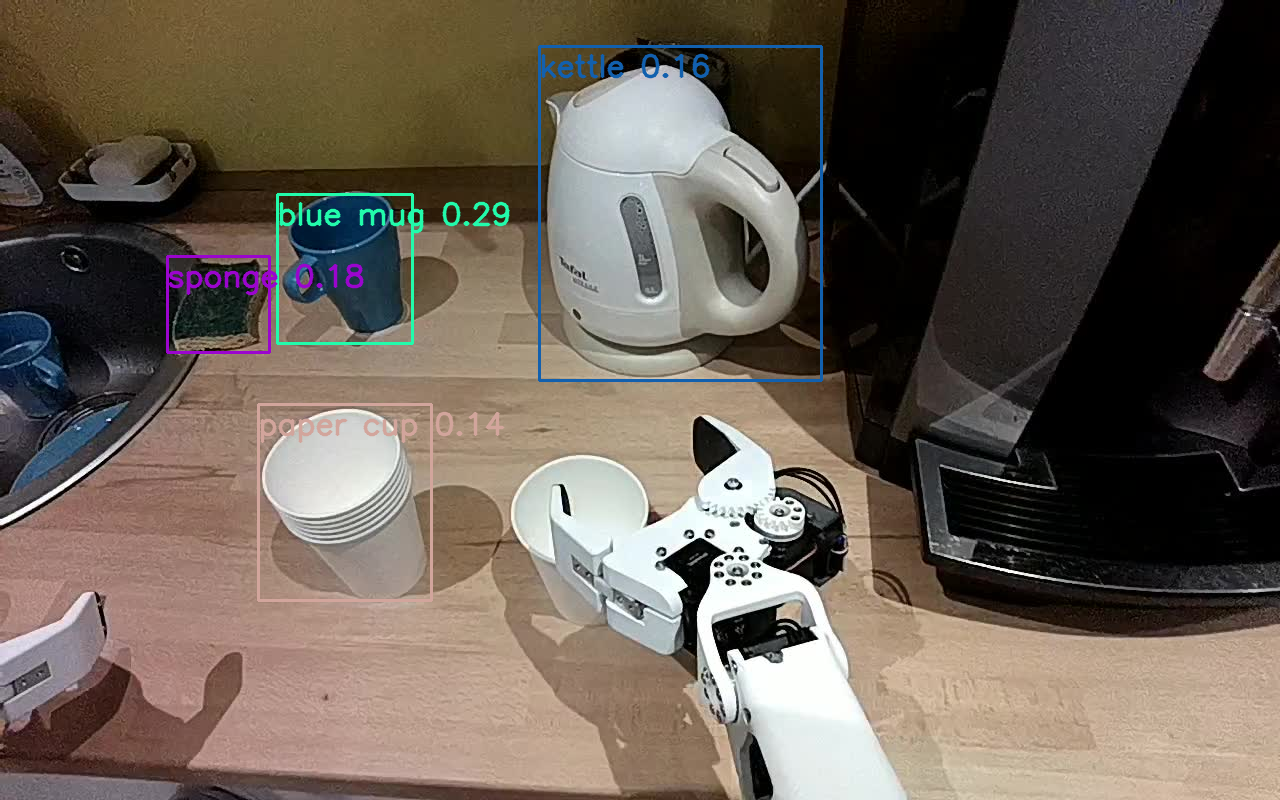

In [16]:
annotator = Annotator()

img_annotated = annotator.annotate(im=img, detection_predictions=predictions)
Image.fromarray(img_annotated)

## At last, the segmentation!

Now that we have the bounding boxes for the objects we are interested in, we can use our SAM wrapper defined earlier to obtain the segmentation of each object.

In [17]:
masks = object_segmentation_wrapper.infer(im=img, bboxes=bboxes)

Note: You could also call `object_segmentation_wrapper.infer(...)` with a list of list of points as input. 
Here, each list of points would correspond to points of interest for each object. An example such a list would be :
```python
points = [[[x1, x2], [x3, x4], ...], [[x5, x6], [x7, x8], ...], ...]
```

You could then call `object_segmentation_wrapper.infer(im=img, points_list=points)`
            

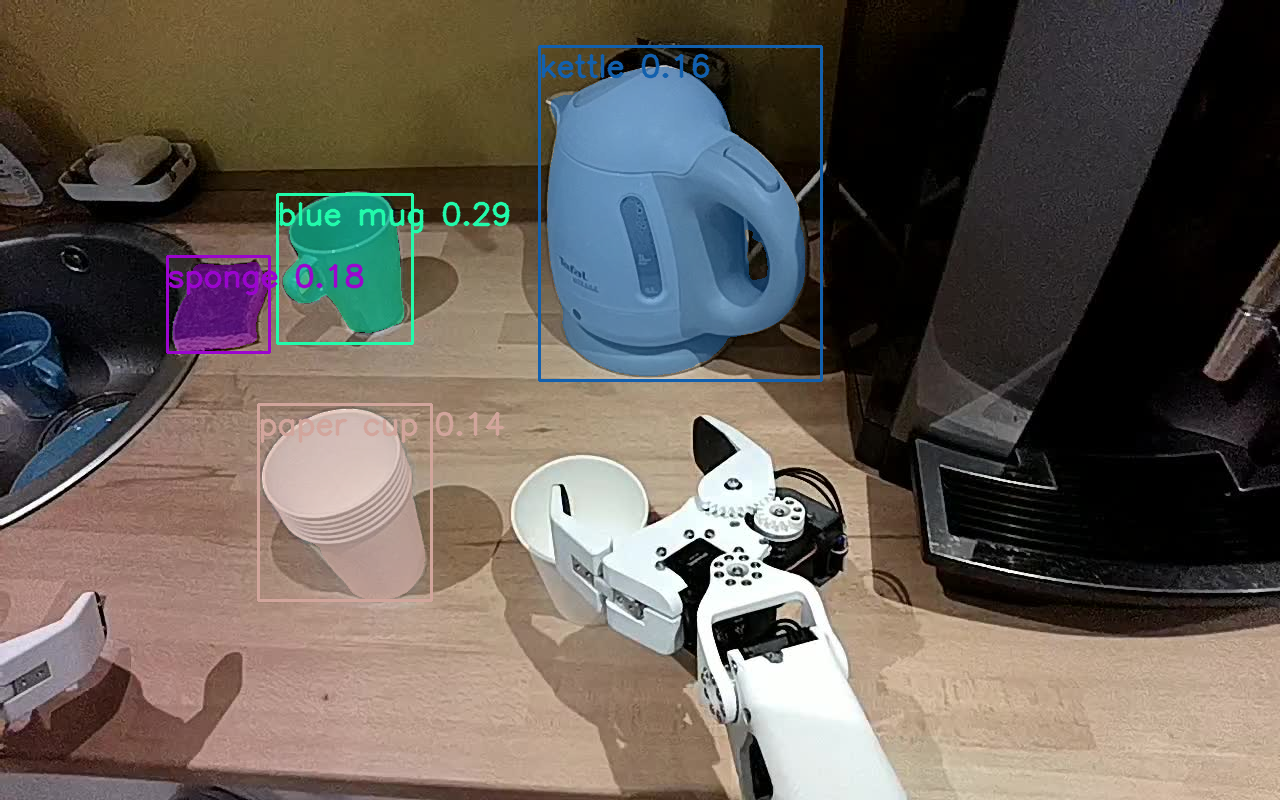

In [18]:
img_annotated = annotator.annotate(im=img, detection_predictions=predictions, masks=masks)
Image.fromarray(img_annotated)